# Step 1: Data Preparation


In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.feature_extraction.text import CountVectorizer
# from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.svm import OneClassSVM
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from textblob import TextBlob
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from bs4 import BeautifulSoup
import requests
import urllib
import emoji
import json
import re

nltk.download("vader_lexicon")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ryanlahlou/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [2]:
# Load data

## Fetch listing data from our (SMARE) API
data = requests.get("https://smare.lryanle.com/api/ext/listings")

if data.status_code == 200:
    data = data.json()

    if data["success"]:
        flagged_listings = pd.DataFrame(data["data"]["flagged"])
        not_flagged_listings = pd.DataFrame(data["data"]["notflagged"])

        flagged_listings["flagged"] = True
        not_flagged_listings["flagged"] = False

        data = pd.concat([flagged_listings, not_flagged_listings], ignore_index=True)

        print("Data retrieved and parsed successfully!")
        print(f"Number of flagged listings: {len(flagged_listings)}")
        print(f"Number of not flagged listings: {len(not_flagged_listings)}")
    else:
        print("API returned an unsuccessful status.")
else:
    print("Failed to retrieve data. Status code:", data.status_code)

Data retrieved and parsed successfully!
Number of flagged listings: 371
Number of not flagged listings: 701


In [3]:
# Listing MSRP (KBB) Data
with open("l_kbb_prices.json", "r") as kbb_file:
    kbb_prices = json.load(kbb_file)
    
def scrape_kbb_price(make, model, year):
    try:
        make_url_part = make.lower().replace(" ", "-")
        model_url_part = model.lower().replace(" ", "-")
        search_url = f"https://www.kbb.com/{make_url_part}/{model_url_part}/{year}/"
        response = requests.get(search_url)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, "html.parser")
        scripts = soup.find_all("script")
        for script in scripts:
            if script.string and '"nationalBaseDefaultPrice"' in script.string:
                start_index = (
                    script.string.find('"nationalBaseDefaultPrice"')
                    + len('"nationalBaseDefaultPrice"')
                    + 1
                )
                end_index = script.string.find(",", start_index)
                kbb_price = script.string[start_index:end_index]

                return int(kbb_price)

        return None
    except Exception as e:
        return None

def get_kbb_value(listing):
    makemodel = f"{listing['make']} {listing['model']} {listing['year']}".lower()
    fallback_makemodel = (
        f"{listing['make']} {listing['model'].split(' ')[0]} {listing['year']}".lower()
    )

    if makemodel in kbb_prices:
        return int(kbb_prices[makemodel])
    elif fallback_makemodel in kbb_prices:
        return int(kbb_prices[fallback_makemodel])
    else:
        return None

def get_msrp_delta(listing):
    kbb_price = get_kbb_value(listing)
    if kbb_price:
        return listing["price"] - kbb_price
    else:
        return None

def normalized_msrp_ratio(listing): 
    kbb_price = get_kbb_value(listing)
    price = listing["price"]
    
    if kbb_price is None:
        return None

    a = 20000
    b = (1.06) ** (1 / 10000)
    rd_kbb = a * (b ** (1.19 * kbb_price)) - a
    
    delta_p = np.abs(price - kbb_price)
    x = delta_p / rd_kbb
    y = 0.26 * x ** 2 + 0.07 * x
    y = max(0, min(1, y))
    
    return y
    
data["msrp_delta"] = data.apply(lambda row: get_msrp_delta(row), axis=1)
data["heuristic_normalized_msrp_ratio"] = data.apply(lambda row: normalized_msrp_ratio(row), axis=1)
print(f"Number of listings with no KBB price: {data['msrp_delta'].isnull().sum()}")

Number of listings with no KBB price: 144


In [4]:
# NHTSA Theft Rate Data
with open("./n_nhtsa_theft_rates.json") as nhtsa_theft_file:
    nhtsa_theft_rates = json.load(nhtsa_theft_file)

def theft_rate(listing):
    makemodel = f"{listing['make']} {listing['model']} {listing['year']}".lower()
    fallback_makemodel = f"{listing['make']} {listing['model'].split(' ')[0]} {listing['year']}".lower()

    if makemodel in nhtsa_theft_rates:
        return float(nhtsa_theft_rates[makemodel])
    elif fallback_makemodel in nhtsa_theft_rates:
        return float(nhtsa_theft_rates[fallback_makemodel])
    
    return 0

data["theft_rate"] = data.apply(lambda row: theft_rate(row), axis=1)
data["theft_rate"].notna().sum()

1072

In [5]:
# Data peek 
data.head()

,_id,title,price,odometer,post_body,year,images,source,make,model,imageCount,flagged,msrp_delta,heuristic_normalized_msrp_ratio,theft_rate
0,7739907799,12%20Ford%20Fusion%20%242%2C500down%20299month,6999,161000.0,QR%20Code%20Link%20to%20This%20Post%0A%0A%0A%2...,2012,[https://images.craigslist.org/00w0w_4qZMlQdzk...,craigslist,ford,Fusion,9.0,True,774.0,0.261556,1.20
1,7739908292,2014%20Nissan%20Juke%20%243%2C500down%20299month,8999,145000.0,QR%20Code%20Link%20to%20This%20Post%0A%0A%0A%2...,2014,[https://images.craigslist.org/00E0E_acjkHCJKO...,craigslist,nissan,Juke,9.0,True,528.0,0.080059,0.49
2,7739769846,2013%20Chevrolet%20Sonic%20%20Runs%20Great%21,4950,197000.0,QR%20Code%20Link%20to%20This%20Post%0A%0A%0ASe...,2013,[https://images.craigslist.org/00Z0Z_dEo4PI4DT...,craigslist,chevrolet,Sonic,16.0,True,-1140.0,0.546570,1.50
3,7740001827,2023%20Ford%20F-150%20Lariat%20SuperCrew%205.5...,34999,13000.0,QR%20Code%20Link%20to%20This%20Post%0A%0A%0A20...,2023,[https://images.craigslist.org/00X0X_3vyW2yH9R...,craigslist,ford,F-150,7.0,True,-1581.0,0.038657,0.00
4,7740002911,2022%20Hyundai%20Venue%20SEL,13999,54990.0,QR%20Code%20Link%20to%20This%20Post%0A%0A%0A20...,2022,[https://images.craigslist.org/00Q0Q_dwmUONfZr...,craigslist,hyundai,Venue,12.0,True,-2887.0,0.432452,0.00


In [6]:
# View data info
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1072 entries, 0 to 1071
Data columns (total 15 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   _id                              1072 non-null   object 
 1   title                            1072 non-null   object 
 2   price                            1072 non-null   int64  
 3   odometer                         1059 non-null   float64
 4   post_body                        1061 non-null   object 
 5   year                             1072 non-null   int64  
 6   images                           1061 non-null   object 
 7   source                           1072 non-null   object 
 8   make                             1072 non-null   object 
 9   model                            1072 non-null   object 
 10  imageCount                       1061 non-null   float64
 11  flagged                          1072 non-null   bool   
 12  msrp_delta          

,price,odometer,year,imageCount,msrp_delta,heuristic_normalized_msrp_ratio,theft_rate
count,1.072000e+03,1.059000e+03,1072.000000,1061.000000,9.280000e+02,9.280000e+02,1072.000000
mean,1.222420e+07,1.018731e+05,2016.504664,16.582469,8.730975e+06,6.581870e-01,0.651203
std,1.353137e+08,8.069412e+04,3.747888,6.593023,1.151456e+08,3.978149e-01,1.314020
min,1.000000e+00,1.000000e+00,2000.000000,2.000000,-2.889178e+06,1.993726e-08,0.000000
25%,7.995000e+03,5.185700e+04,2014.000000,11.000000,-4.660000e+03,1.989861e-01,0.000000
50%,1.499950e+04,9.620800e+04,2017.000000,17.000000,-3.975000e+02,1.000000e+00,0.000000
75%,2.500000e+04,1.380000e+05,2020.000000,24.000000,3.748250e+03,1.000000e+00,0.830000
max,2.000021e+09,1.111111e+06,2024.000000,24.000000,2.000018e+09,1.000000e+00,11.940000


In [7]:
# Drop rows with missing values
data.isnull().sum()
data = data.dropna()
data.isnull().sum()

_id                                0
title                              0
price                              0
odometer                           0
post_body                          0
year                               0
images                             0
source                             0
make                               0
model                              0
imageCount                         0
flagged                            0
msrp_delta                         0
heuristic_normalized_msrp_ratio    0
theft_rate                         0
dtype: int64

In [8]:
if "title" in data.columns and "post_body" in data.columns:
    data["title"] = data["title"].apply(lambda x: urllib.parse.unquote(x) if isinstance(x, str) else x)
    data["post_body"] = (
        data["post_body"]
        .apply(lambda x: urllib.parse.unquote(x) if isinstance(x, str) else x)
        .apply(lambda x: x.replace("QR Code Link to This Post\n\n\n", "") if isinstance(x, str) else x)
        .apply(lambda x: x.replace("\n", " ") if isinstance(x, str) else x)
    )

In [9]:
# Feature Engineering
data["post_length"] = data["post_body"].apply(len)
data["emoji_ratio"] = data["post_body"].apply(
    lambda x: emoji.emoji_count(x) / len(x) if len(x) > 0 else 0
)
data["contains_vin"] = (
    data["post_body"].str.contains(r"(?=.*[0-9])(?=.*[A-z])[0-9A-z-]{17}").astype(int)
)
data["cashonly_mention"] = (
    data["post_body"].str.contains(r"(?=.*cash)(?=.*only)").astype(int)
)
data["is_dealership"] = (
    data["post_body"]
    .apply(
        lambda x: sum(
            bool(re.search(pattern, x, re.IGNORECASE))
            for pattern in [
                r"llc",
                r"dealership",
                r"financing",
                r"return",
                r"policy",
                r"stock",
                r"retailer",
                r"batch",
                r"approv",
                r"trade",
                r"warrant",
                r"credit",
                r"https?:\/\/[\w\.-]+(?:\.[\w\.-]+)+[\w\-\._~:/?#[\]@!$&\'()*+,;=]+",
            ]
        )
        >= 2
    )
    .astype(int)
)
data["model_freq"] = data["model"].map(data["model"].value_counts(normalize=True))
data["capital_ratio"] = data["post_body"].apply(
    lambda x: sum(1 for c in x if c.isupper()) / len(x)
)

# Remove unnecessary columns
data = data.drop(columns=["images", "_id"])

In [10]:
# Sentiment Analysis (Polarity, Emotion, Urgency)
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return "positive"
    elif polarity < 0:
        return "negative"
    else:
        return "neutral"


def get_emotions(text):
    sid = SentimentIntensityAnalyzer()
    scores = sid.polarity_scores(text)
    if scores["compound"] >= 0.05:
        return "happy"
    elif scores["compound"] <= -0.05:
        return "sad"
    else:
        return "neutral"


def check_urgency(text):
    urgent_keywords = (
        "urgent|immediate|important|critical|emergency|now|asap|rush|priority|quick|alert|crisis|necessary|"
        "sudden|expedite|hurry|prompt|time-sensitive|pressing|rapid|deadline|dire|instant|need|fast|speedy|"
        "soonest|warning|breakthrough|vital|imperative|fleeting|momentary|quickly|press|haste|demand|rescue|"
        "help|assist|save|fix|solve|address|respond|action|handle|manage|attend|desperate|serious|compulsory|"
        "mandatory|required|essential|crucial|pivotal|decisive|exigent|clutch|paramount|chief|primary|principal|"
        "major|significant|response|delay|attention|care|request|situation|matter|immediately"
    )
    if re.search(urgent_keywords, text, re.IGNORECASE):
        return "urgent"
    else:
        return "not urgent"


data["sentiment"] = data["post_body"].apply(get_sentiment)
data["emotion"] = data["post_body"].apply(get_emotions)
data["urgency"] = data["post_body"].apply(check_urgency)

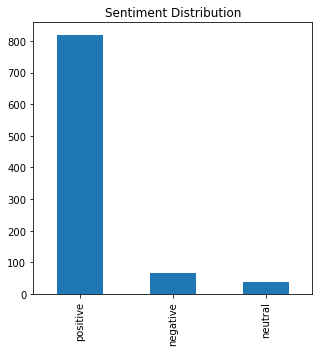

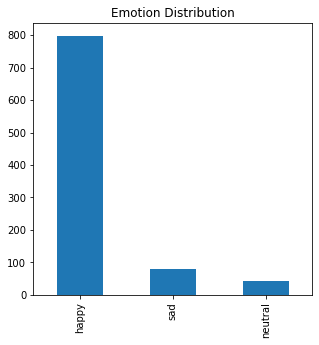

In [11]:
# View sentiment distribution
data["sentiment"].value_counts().plot(kind="bar", title="Sentiment Distribution", figsize=(5,5))
plt.show()
data["emotion"].value_counts().plot(kind="bar", title="Emotion Distribution", figsize=(5,5))
plt.show()

In [12]:
# drop title and post_body
data = data.drop(columns=["title", "post_body"])

# count unique values for source, make, model, sentiment, emotion, urgency
print(
    data["source"].nunique(),
    data["make"].nunique(),
    data["model"].nunique(),
    data["sentiment"].nunique(),
    data["emotion"].nunique(),
    data["urgency"].nunique(),
)

categorical_columns = ["source", "make", "model", "sentiment", "emotion", "urgency"]
data = pd.get_dummies(data, columns=categorical_columns)

2 35 262 3 3 2


# Step 2: Exploratory Data Analysis (EDA)

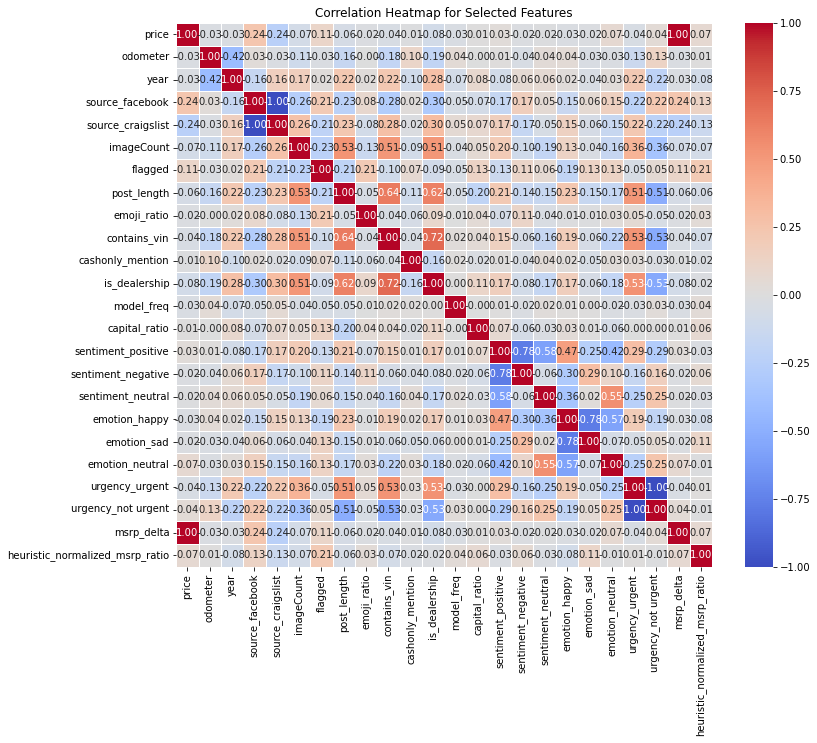

In [13]:
selected_columns = [
    "price",
    "odometer",
    "year",
    "source_facebook",
    "source_craigslist",
    "imageCount",
    "flagged",
    "post_length",
    "emoji_ratio",
    "contains_vin",
    "cashonly_mention",
    "is_dealership",
    "model_freq",
    "capital_ratio",
    "sentiment_positive",
    "sentiment_negative",
    "sentiment_neutral",
    "emotion_happy",
    "emotion_sad",
    "emotion_neutral",
    "urgency_urgent",
    "urgency_not urgent",
    "msrp_delta",
    "heuristic_normalized_msrp_ratio"
]

# Filter the DataFrame to include only the selected columns
filtered_data = data[selected_columns]

# Calculate the correlation matrix
correlation_matrix = filtered_data.corr()

# Create the heatmap
plt.figure(figsize=(12, 10))  # You can adjust the size as needed
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", linewidths=0.5, fmt=".2f")
plt.title("Correlation Heatmap for Selected Features")
plt.show()

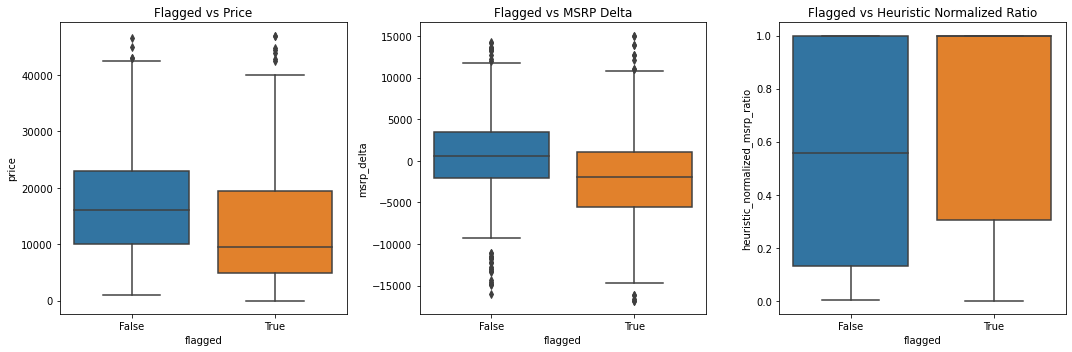

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt


data_nooutliers = data.copy()

# price column
Q1 = data_nooutliers['price'].quantile(0.25)
Q3 = data_nooutliers['price'].quantile(0.75)
IQR = Q3 - Q1
data_nooutliers = data_nooutliers[(data_nooutliers['price'] >= Q1 - 1.5 * IQR) & (data_nooutliers['price'] <= Q3 + 1.5 * IQR)]

# msrp_delta column
Q1 = data_nooutliers['msrp_delta'].quantile(0.25)
Q3 = data_nooutliers['msrp_delta'].quantile(0.75)
IQR = Q3 - Q1
data_nooutliers = data_nooutliers[(data_nooutliers['msrp_delta'] >= Q1 - 1.5 * IQR) & (data_nooutliers['msrp_delta'] <= Q3 + 1.5 * IQR)]

# heuristic_normalized_ratio column
Q1 = data_nooutliers['heuristic_normalized_msrp_ratio'].quantile(0.25)
Q3 = data_nooutliers['heuristic_normalized_msrp_ratio'].quantile(0.75)
IQR = Q3 - Q1
data_nooutliers = data_nooutliers[(data_nooutliers['heuristic_normalized_msrp_ratio'] >= Q1 - 1.5 * IQR) & (data_nooutliers['heuristic_normalized_msrp_ratio'] <= Q3 + 1.5 * IQR)]

# Graphs
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.boxplot(x='flagged', y='price', data=data_nooutliers, ax=axes[0])
axes[0].set_title('Flagged vs Price')
sns.boxplot(x='flagged', y='msrp_delta', data=data_nooutliers, ax=axes[1])
axes[1].set_title('Flagged vs MSRP Delta')
sns.boxplot(x='flagged', y='heuristic_normalized_msrp_ratio', data=data_nooutliers, ax=axes[2])
axes[2].set_title('Flagged vs Heuristic Normalized Ratio')

plt.tight_layout()
plt.show()

# Step 3: Data split

In [15]:
# Split data into features and target
X = data.drop("flagged", axis=1)
y = data["flagged"]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [16]:
def plot_model_results(predictions, actual, title):
    df = pd.DataFrame({'Actual': actual, 'Prediction': predictions})
    cross_tab = pd.crosstab(df['Prediction'], df['Actual'], normalize='index')

    fig, ax = plt.subplots(figsize=(8, 4))
    sns.heatmap(cross_tab, annot=True, fmt=".2f", cmap="Blues", ax=ax)
    plt.title(title)
    plt.ylabel('Predicted Label')
    plt.xlabel('Actual Label')
    plt.show()

# Step 4 - Isolation Forest (Training, Validation, & Evaluation)

Number of anomalies detected: 0


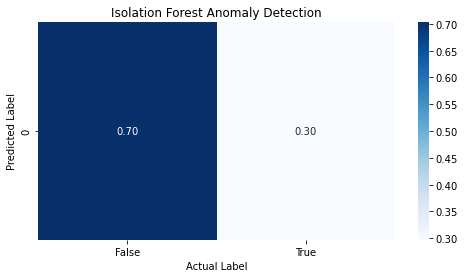

Classification Report:
               precision    recall  f1-score   support

           0       0.30      1.00      0.46        82
           1       0.00      0.00      0.00       194

    accuracy                           0.30       276
   macro avg       0.15      0.50      0.23       276
weighted avg       0.09      0.30      0.14       276

Accuracy Score: 0.2971014492753623


/Users/ryanlahlou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ryanlahlou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ryanlahlou/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [17]:
# Step 6 - Anomaly Detection using Isolation Forest
iso_forest = IsolationForest(n_estimators=100, contamination='auto', random_state=42)
iso_forest.fit(X_train)

# Predict anomalies on the test set
anomalies = iso_forest.predict(X_test)
# Transform predictions where -1 indicates anomaly and 1 indicates normal
anomalies = np.where(anomalies == 1, 0, 1)

print("Number of anomalies detected:", np.sum(anomalies))

# Evaluating Isolation Forest
plot_model_results(anomalies, y_test, 'Isolation Forest Anomaly Detection')

y_test_transformed = np.where(y_test == 1, 0, 1)
print("Classification Report:\n", classification_report(y_test_transformed, anomalies))
print("Accuracy Score:", accuracy_score(y_test_transformed, anomalies))

# Step 4 - KMeans (Training, Validation, & Evaluation)

0    906
4      9
1      2
2      2
3      1
Name: cluster, dtype: int64


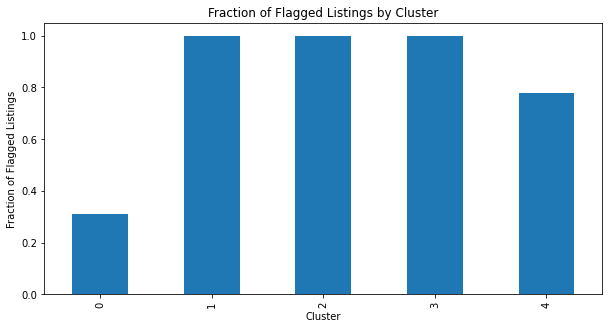

K-means Clustering Evaluation:
Classification Report:
               precision    recall  f1-score   support

       False       0.72      1.00      0.84       194
        True       1.00      0.07      0.14        82

    accuracy                           0.72       276
   macro avg       0.86      0.54      0.49       276
weighted avg       0.80      0.72      0.63       276

Accuracy Score: 0.7246376811594203


In [18]:
# K-means Clustering
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(X_train)

clusters = kmeans.predict(X)
data['cluster'] = clusters

# Explore cluster distribution
print(data['cluster'].value_counts())

cluster_flagged_distribution = data.groupby('cluster')['flagged'].mean()

plt.figure(figsize=(10, 5))
cluster_flagged_distribution.plot(kind='bar')
plt.title('Fraction of Flagged Listings by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Fraction of Flagged Listings')
plt.show()

# Determining if a cluster is flagged based on the majority of its entries
cluster_labels = data.groupby('cluster')['flagged'].mean() > 0.5
data['predicted_flagged'] = data['cluster'].map(cluster_labels)

# Ensure the indices of X_test are used to fetch the correct predictions
test_indices = X_test.index
kmeans_predictions = data.loc[test_indices, 'predicted_flagged']

print("K-means Clustering Evaluation:")
print("Classification Report:\n", classification_report(y_test, kmeans_predictions))
print("Accuracy Score:", accuracy_score(y_test, kmeans_predictions))

# Step 4 - One-Class SVM (Training, Validation, & Evaluation)

Number of outliers detected by One-Class SVM: 266


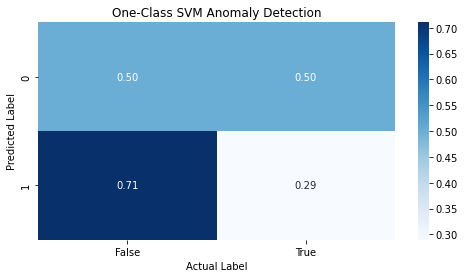

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.06      0.11        82
           1       0.71      0.97      0.82       194

    accuracy                           0.70       276
   macro avg       0.61      0.52      0.47       276
weighted avg       0.65      0.70      0.61       276

Accuracy Score: 0.7028985507246377


In [19]:
# One-Class SVM (Anomaly Detection)
one_class_svm = OneClassSVM(kernel='rbf', gamma='auto', nu=0.01)
one_class_svm.fit(X_train)

# Test: -1 indicates = outlier, 1 = normal
svm_predictions = one_class_svm.predict(X_test)
# 0 = normal, 1 = anomaly
svm_outliers = np.where(svm_predictions == 1, 0, 1)

print("Number of outliers detected by One-Class SVM:", np.sum(svm_outliers))
plot_model_results(svm_outliers, y_test, 'One-Class SVM Anomaly Detection')

y_test_transformed = np.where(y_test == 1, 0, 1)
print("Classification Report:\n", classification_report(y_test_transformed, svm_outliers))
print("Accuracy Score:", accuracy_score(y_test_transformed, svm_outliers))

# Step 4 - Random Forest (Training, Validation, & Evaluation)

In [20]:
# RF Classifier Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Hyperparameter tuning using GridSearch
param_grid = {
    "n_estimators": [50, 100, 200],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [4, 5, 6, 7, 8],
    "criterion": ["gini", "entropy"],
}
CV_rfc = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5
)
CV_rfc.fit(X_train, y_train)
print("Best parameters:", CV_rfc.best_params_)

# Evaluate model performance
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

Best parameters: {'criterion': 'gini', 'max_depth': 6, 'max_features': 'auto', 'n_estimators': 50}
Classification Report:
               precision    recall  f1-score   support

       False       0.81      0.90      0.86       194
        True       0.69      0.51      0.59        82

    accuracy                           0.79       276
   macro avg       0.75      0.71      0.72       276
weighted avg       0.78      0.79      0.78       276

Confusion Matrix:
 [[175  19]
 [ 40  42]]
Accuracy Score: 0.7862318840579711


# Step 4 - Random Forest w/ SMOTE (Training, Validation, & Evaluation)

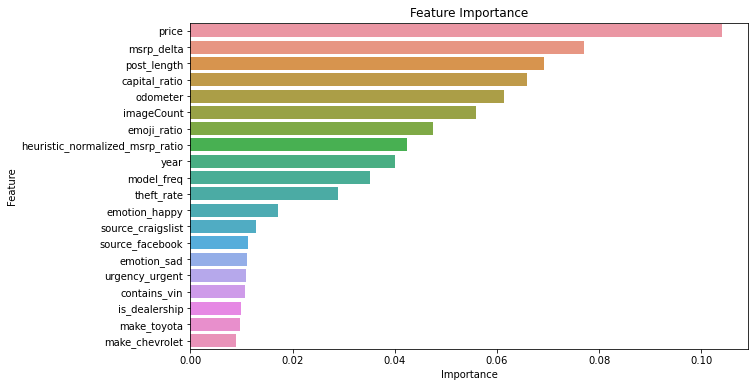

In [23]:
# Get most important features
feature_importances = model.feature_importances_
features = X.columns
feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df[:20])
plt.title('Feature Importance')
plt.show()


In [21]:
# RF w/ SMOTE (Synthetic Minority Over-sampling Technique)
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
CV_rfc = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, scoring='accuracy')
CV_rfc.fit(X_resampled, y_resampled)
print("Best parameters:", CV_rfc.best_params_)

best_model = CV_rfc.best_estimator_
y_pred = best_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Accuracy Score:", accuracy_score(y_test, y_pred))


KeyboardInterrupt: 

# Step 4 - LR + RF + SVM Ensemble (Training, Validation, & Evaluation)

In [ ]:
# LR + RF + SVM Ensemble Model
log_clf = LogisticRegression(random_state=42)
rf_clf = RandomForestClassifier(random_state=42, n_estimators=100)
svm_clf = SVC(random_state=42, probability=True)

voting_clf = VotingClassifier(estimators=[('lr', log_clf), ('rf', rf_clf), ('svc', svm_clf)], voting='soft')
voting_clf.fit(X_resampled, y_resampled)
y_pred_ensemble = voting_clf.predict(X_test)

print("Ensemble Model Classification Report:\n", classification_report(y_test, y_pred_ensemble))
print("Ensemble Model Confusion Matrix:\n", confusion_matrix(y_test, y_pred_ensemble))
print("Ensemble Model Accuracy Score:", accuracy_score(y_test, y_pred_ensemble))

Ensemble Model Classification Report:
               precision    recall  f1-score   support

       False       0.85      0.75      0.80       195
        True       0.53      0.68      0.60        81

    accuracy                           0.73       276
   macro avg       0.69      0.72      0.70       276
weighted avg       0.76      0.73      0.74       276

Ensemble Model Confusion Matrix:
 [[147  48]
 [ 26  55]]
Ensemble Model Accuracy Score: 0.7318840579710145
